In [1]:
%matplotlib inline

In [12]:
import geopandas as gpd
import pandas as pd
from distmetrics import compute_mahalonobis_dist_2d
import matplotlib.pyplot as plt
import warnings

# Sites

In [13]:
df_sites = gpd.read_file('data/val_sites_subset.geojson')
df_sites.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,T036-076228-IW3,POINT (19.33289 4.5749)
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T108-230715-IW2,POINT (48.77698 31.7549)
2,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T101-214979-IW1,POINT (48.77698 31.7549)
3,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T014-028130-IW2,POINT (36.61178 35.52891)
4,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T021-043823-IW2,POINT (36.61178 35.52891)


In [4]:
df_sites.drop(columns=['change_time', 'last_observation_time']).explore(categorical=True, column='change_type', legend=True, marker_kwds={'radius':10})

# Bursts

In [5]:
SITE_ID = 4

In [6]:
df_site = df_sites[df_sites.site_id == SITE_ID].reset_index(drop=True)
df_site

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,T036-076228-IW3,POINT (19.33289 4.5749)


In [7]:
df_val_bursts = gpd.read_parquet('data/validation_bursts_v1_coverage_updated.parquet')
df_val_bursts.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T005-008692-IW2,"POLYGON ((-97.21446 17.86505, -97.21446 17.864...",104,72
1,T008-015865-IW2,"POLYGON ((-1.50129 41.44183, -1.5013 41.44156,...",101,150
2,T012-024584-IW1,"POLYGON ((-103.78409 20.20832, -103.78409 20.2...",101,34
3,T014-028130-IW2,"POLYGON ((37.01648 35.59545, 37.01649 35.59518...",100,22
4,T014-028131-IW2,"POLYGON ((36.98085 35.76145, 36.98085 35.76118...",38,22


In [8]:
df_bursts_for_site = df_val_bursts[df_val_bursts.jpl_burst_id.isin(df_site.jpl_burst_id)].reset_index(drop=True)
df_bursts_for_site.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T036-076228-IW3,"POLYGON ((19.11752 4.76859, 19.11752 4.76723, ...",100,4


# Time Series

In [9]:
BURST_ID = df_bursts_for_site['jpl_burst_id'].iloc[0].replace('_', '-').upper()  # 't088_187104_iw2'.replace('_', '-').upper()

In [10]:
ts_csv = f'data/rtc_ts_by_site/rtc_summary_burst_{BURST_ID}_site{SITE_ID}.csv'
ts_csv

'data/rtc_ts_by_site/rtc_summary_burst_T036-076228-IW3_site4.csv'

In [11]:
# sample path 'data/rtc_ts_by_site/rtc_summary_burst_T088-187104-IW2_site274.csv'
df_rtc_ts_wind = pd.read_csv(ts_csv).drop(columns=['Unnamed: 0'])
df_rtc_ts_wind['datetime'] = pd.to_datetime(df_rtc_ts_wind['datetime'])
df_rtc_ts_wind.head()

NameError: name 'pd' is not defined

In [ ]:
import ast
# Function to convert string
def convert_to_list(v):
    if isinstance(v, str):
        return ast.literal_eval(v)
    return v

In [ ]:
# Convert srting to list
df_rtc_ts_wind['vv_l'] = df_rtc_ts_wind['vv'].apply(convert_to_list)
df_rtc_ts_wind['vh_l'] = df_rtc_ts_wind['vh'].apply(convert_to_list)
df_rtc_ts_wind['vv/vh_l'] = df_rtc_ts_wind['vv/vh'].apply(convert_to_list)

# get average value for window
df_rtc_ts_wind['vv_avg'] = df_rtc_ts_wind['vv_l'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)#.rolling(3).sum()
df_rtc_ts_wind['vh_avg'] = df_rtc_ts_wind['vh_l'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)#.rolling(3).sum()
df_rtc_ts_wind['vh_center'] = df_rtc_ts_wind['vh_l'].apply(lambda x: np.array(x).reshape((3, 3))[1, 1] if isinstance(x, list) else x)#.rolling(3).sum()

df_rtc_ts_wind['vv/vh_avg'] = df_rtc_ts_wind['vv/vh_l'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)
df_rtc_ts_wind.head()

In [ ]:
POL_RATIO_PLOT = False

In [ ]:
fig, ax1 = plt.subplots(figsize=(25, 5))
ax1.plot(df_rtc_ts_wind['datetime'], df_rtc_ts_wind['vv_avg'], marker='o', color='tab:blue', label='vv_avg')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('vv_avg', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df_rtc_ts_wind['datetime'], df_rtc_ts_wind['vh_avg'], marker='v', color='tab:brown', label='vh_avg')
ax2.set_ylabel('vh_avg', color='tab:brown')
ax2.tick_params(axis='y', labelcolor='tab:brown')
if POL_RATIO_PLOT:
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  
    ax3.plot(df_rtc_ts_wind['datetime'], df_rtc_ts_wind['vv/vh_avg'], marker='P', color='tab:purple', label='vv/vh_avg')
    ax3.set_ylabel('vv/vh_avg', color='tab:purple')
    ax3.tick_params(axis='y', labelcolor='tab:purple')

change_type = df_site.change_type.iloc[0]
plt.title(f'Change type {change_type}; {BURST_ID=}; {SITE_ID=}')
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    ax1.set_xticks(df_rtc_ts_wind['datetime'].tolist())
    ax1.set_xticklabels(df_rtc_ts_wind['datetime'].tolist(), rotation=90)

ax1.grid(True)

last_observed_time = df_site['last_observation_time'][0]

if last_observed_time == pd.NaT:
    ax1.axvline(x=last_observed_time, color='b', linestyle='--', label=f'Last observation time ({last_observed_time})')
ax2.legend(loc='upper left')

change_time = df_site['change_time'][0]
ax1.axvline(x=change_time, color='r', linestyle='--', label=f'Change time ({change_time})')
ax1.legend()
plt.show()

- Change "accuracy" - take 1 - if first changed observation occurs after "last_observation_time" and within 1 acquisition after "change_time" then that is "perfect" accuracy.
- Change "accuracy" - take 2 - relaxed - if first changed observation occurs after last observation time or within a set time frame that is user defined.


In [ ]:
# df_site.drop(columns=['change_time', 'last_observation_time']).explore(categorical=True, column='change_type', legend=True, marker_kwds={'radius':10})

# Mahalanobis 1d Distance Running

In [ ]:
from distmetrics import compute_mahalonobis_dist_2d, compute_mahalonobis_dist_1d
import numpy as np
from tqdm import tqdm

In [ ]:
def window_mahalanobis_1d_running(window_data: list[list], n_pre_img: int = 5):
    arrs = [np.array(window_l).reshape((3, 3)) for window_l in window_data]
    N = len(arrs)
    dists = [compute_mahalonobis_dist_1d(arrs[k- n_pre_img : k ], arrs[k]) if k > n_pre_img else None for k in tqdm(range(N))]
    return dists
dist_objs = window_mahalanobis_1d_running(df_rtc_ts_wind['vh_l'])
dist_vals = [d_obj.dist[1, 1] if d_obj is not None else np.nan for d_obj in dist_objs]
dist_dts = [df_rtc_ts_wind['datetime'][k] for (k, d_obj) in enumerate(dist_objs) if d_obj is not None]
dist_plot = [dist_obj.dist[1, 1] for dist_obj in dist_objs if dist_obj is not None]

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.scatter(dist_dts, dist_plot, marker='s')
ax.plot(dist_dts, dist_plot)
ax.set_xlabel('Acquisition Time of Post Image')
ax.set_ylabel('Mahalanobis Distance VH')
ax.hlines(3, dist_dts[0], dist_dts[-1], ls='--')

# Example Workflow

In [ ]:
T = 3
def window_mahalanobis_1d_workflow(window_data: list[list], n_pre_img: int = 5, n_post_imgs_to_confirm: int = 3):
    arrs = [np.array(window_l).reshape((3, 3)) for window_l in window_data]
    N = len(arrs)
    dist_objs = [compute_mahalonobis_dist_1d(arrs[i - n_pre_img : i], 
                                             [arrs[i + j] for j in range(n_post_imgs_to_confirm)],
                                             window_size=3) 
                 if (i > n_pre_img) and (i + n_pre_img - 1) < N 
                 else None 
                 for i in tqdm(range(N))]
    # 1 for change and 0 elsewhere
    # note the [1, 1] indexing!
    change_pts_init = [int(all([d[1, 1] > T for d in dist_ob.dist])) if dist_ob is not None else 0 for dist_ob in dist_objs]
    # Change
    try:
        ind_c = change_pts_init.index(1)
        change_pts = [int(ind >= ind_c) for ind in range(len(change_pts_init))]
    # No Change
    except ValueError:
        change_pts = change_pts_init
    return np.array(change_pts)

In [118]:
y_obs = window_mahalanobis_1d_workflow(df_rtc_ts_wind['vh_l'])

100%|█████████████████████████████| 100/100 [00:00<00:00, 2274.48it/s]


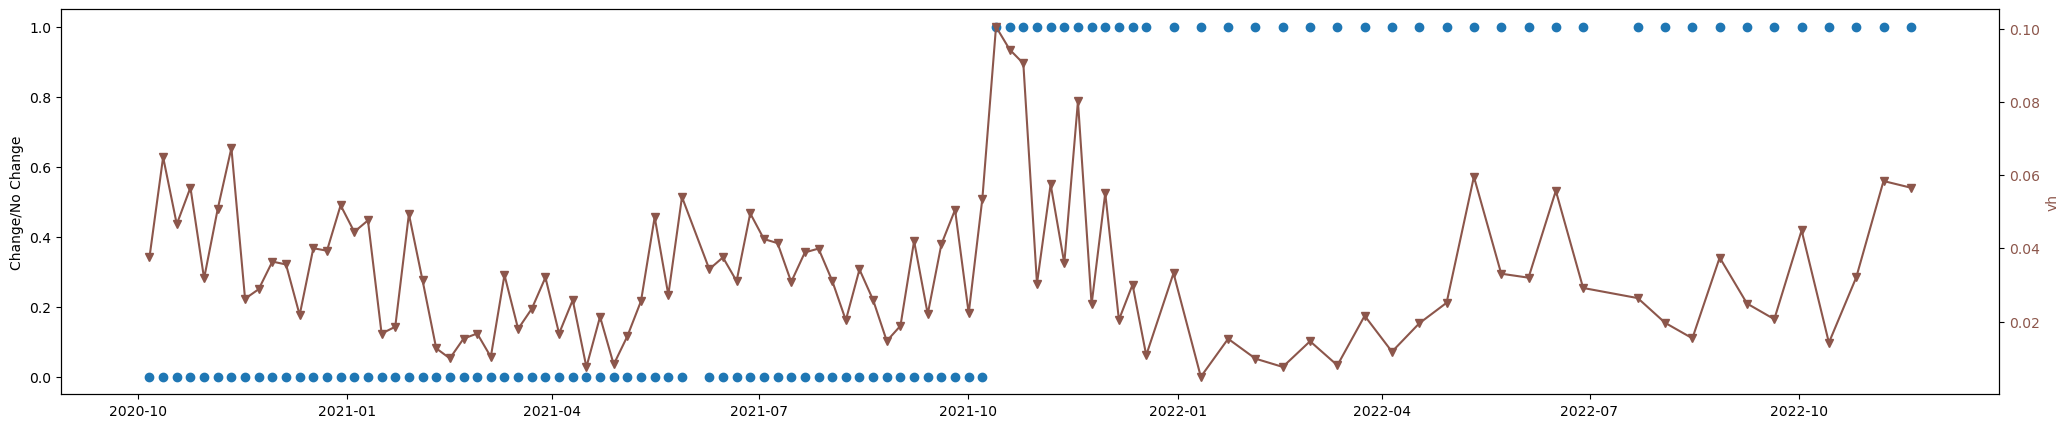

In [124]:
fig, ax1 = plt.subplots(figsize=(25, 5))


ax1.scatter(df_rtc_ts_wind['datetime'], y_obs)
ax1.set_ylabel('Change/No Change')
ax1.set_ylim(-.05, 1.05)
ax2 = ax1.twinx()
bs = df_rtc_ts_wind['vh_center']#.rolling(3).sum()
ax2.plot(df_rtc_ts_wind['datetime'], bs, 
         marker='v', color='tab:brown', label='vh_avg')
ax2.set_ylabel('vh', color='tab:brown')
ax2.tick_params(axis='y', labelcolor='tab:brown')

# Accuracy

Let's just compare data directly and get accuracy per site.

In [136]:
change_time = df_site['change_time'][0]
last_observation_time = df_site['last_observation_time'][0]

FIRST_OBSERVATION_VAL_DATA = pd.Timestamp('2021-10-01')
NODATA_VAL = 3

def generate_val_vec(s1_observations: pd.Series,
                     last_observed: pd.Timestamp, 
                     change_time: pd.Timestamp, 
                            ) -> np.ndarray:
    """
    0 = no change
    1 = change
    2 = either change / no change
    255 = nodata
    """
    y_val = np.zeros(s1_observations.shape[0], dtype=np.uint8)
    y_val[s1_observations < FIRST_OBSERVATION_VAL_DATA] = NODATA_VAL
    
    # No change
    if isinstance(change_time, type(pd.NaT)):
        pass
    # Change
    else:
        # after change time - these are definite change observations
        y_val[(s1_observations >= change_time)] = 1
        # between change time and last observations - these are indeterminate
        if isinstance(last_observed_time, type(pd.NaT)):
            y_val[s1_observations < change_time] = 2
        else:
            ind = (s1_observations < change_time) & (s1_observations > last_observed_time)
            y_val[ind] = 2
    return y_val

def get_total_accuracy(y_val, y_obs) -> float:
    mask = y_val == 255

    acc = ((y_val == 2) | (y_val == y_obs)).sum() / (~mask).sum()
    return acc

def get_user_change_accuracy(y_val, y_obs) -> float:
    mask = y_val == 255
    y_val_is_1 = (y_val == 1)
    
    if y_val_is_1.sum() == 0:
        user_acc = np.nan
    else:
        user_acc = (y_val_is_1 & (y_obs == 1)).sum() / (y_val_is_1 & (y_val != 2) & ~mask).sum()
    return user_acc


def get_producer_change_accuracy(y_val, y_obs) -> float:
    mask = y_val == 255
    y_obs_is_1 = (y_obs == 1)
    
    if y_obs_is_1.sum() == 0:
        prod_acc = np.nan
    else:
        prod_acc = (y_obs_is_1 & (y_val == 1)).sum() / (y_obs_is_1 & (y_val != 2) & ~mask).sum()
    return prod_acc

In [137]:
y_val = generate_val_vec(df_rtc_ts_wind.datetime, last_observation_time, change_time)
prod_acc = get_producer_change_accuracy(y_val, y_obs)
user_acc = get_user_change_accuracy(y_val, y_obs)
total_acc = get_total_accuracy(y_val, y_obs)

print(f'{total_acc=} {user_acc=} {prod_acc=}')

total_acc=0.37 user_acc=1.0 prod_acc=0.8947368421052632


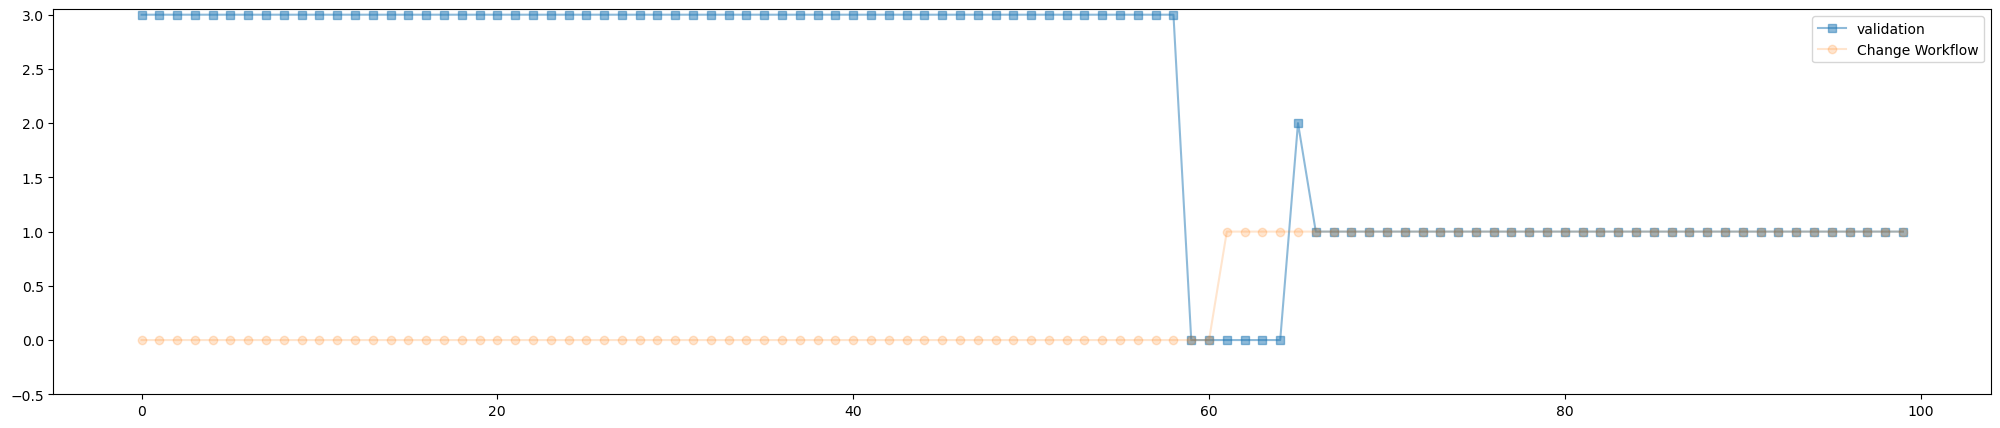

In [139]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(y_val, marker='s', label='validation', alpha=.5)
ax.plot(y_obs, marker='o', label='Change Workflow', alpha=.2)
ax.set_ylim(-0.5, 3.05)
plt.legend()

# To Dos

1. standardize jpl burst id throughout data
2. for validation bursts - nice to have counts of RTC data available
3. Missing Sites
4. Metrics
   - Mahalanobis Distance
   - Z-score for VH polarization (vegetation)
   - DB difference between post and mean (or median) of pre
5. Figure out how to generate Sample Workflow for computing accuracies across different metrics.